In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

# installing/upgrading fastbook
!pip install --upgrade fastbook

#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.4 MB/s eta 0:00:00:00:010:01


In [2]:
%matplotlib inline

#hide
from fastbook import *

In [3]:
path = untar_data(URLs.IMAGENETTE_160)


In [4]:
t = get_image_files(path)
t[0]

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_27613.JPEG')

https://docs.python.org/3/library/glob.html

In [6]:
from glob import glob
files = L(glob(f'{path}/**/*.JPEG', recursive=True)).map(Path)
files[0]

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_27613.JPEG')

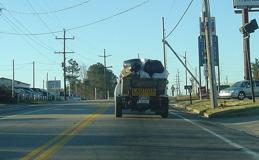

In [7]:
im = Image.open(files[5])
im

In [8]:
lbls = files.map(Self.parent.name()).unique(); lbls

(#10) ['n03417042','n03425413','n01440764','n02102040','n03888257','n03000684','n03445777','n03394916','n03028079','n02979186']

In [9]:
v2i = lbls.val2idx(); v2i

{'n03417042': 0,
 'n03425413': 1,
 'n01440764': 2,
 'n02102040': 3,
 'n03888257': 4,
 'n03000684': 5,
 'n03445777': 6,
 'n03394916': 7,
 'n03028079': 8,
 'n02979186': 9}

In [11]:
??lbls

Type:        L
String form: ['n03417042', 'n03425413', 'n01440764', 'n02102040', 'n03888257', 'n03000684', 'n03445777', 'n03394916', 'n03028079', 'n02979186']
Length:      10
File:        /opt/conda/lib/python3.10/site-packages/fastcore/foundation.py
Source:     
class L(GetAttr, CollBase, metaclass=_L_Meta):
    "Behaves like a list of `items` but can also index with list of indices or masks"
    _default='items'
    def __init__(self, items=None, *rest, use_list=False, match=None):
        if (use_list is not None) or not is_array(items):
            items = listify(items, *rest, use_list=use_list, match=match)
        super().__init__(items)

    @property
    def _xtra(self): return None
    def _new(self, items, *args, **kwargs): return type(self)(items, *args, use_list=None, **kwargs)
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else L(self._get(idx), use_list=None)
    def copy(self): return self._new(self.items.copy())

    def _get(self, i):
       

In [10]:
class Dataset:
    def __init__(self, fns): self.fns=fns
    def __len__(self): return len(self.fns)
    def __getitem__(self, i):
        im = Image.open(self.fns[i]).resize((64,64)).convert('RGB')
        y = v2i[self.fns[i].parent.name]
        return tensor(im).float()/255, tensor(y)

In [11]:
train_filt = L(o.parent.parent.name=='train' for o in files)
train,valid = files[train_filt],files[~train_filt]
len(train),len(valid)

(9469, 3925)

In [12]:
train_ds,valid_ds = Dataset(train),Dataset(valid)
x,y = train_ds[0]
x.shape,y

(torch.Size([64, 64, 3]), tensor(0))

In [87]:
train.dl


AttributeError: 'list' object has no attribute 'dl'

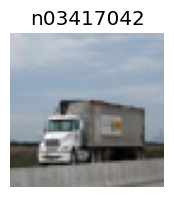

In [13]:
show_image(x, title=lbls[y]);

In [14]:
def collate(idxs, ds): 
    xb,yb = zip(*[ds[i] for i in idxs])
    return torch.stack(xb),torch.stack(yb)

In [15]:
x,y = collate([1,2], train_ds)
x.shape,y

(torch.Size([2, 64, 64, 3]), tensor([0, 0]))

In [16]:
class DataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        print('in dataloader')
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(collate, chunks, ds=self.ds)

In [17]:
train[0]

Path('/root/.fastai/data/imagenette2-160/train/n03417042/n03417042_27613.JPEG')

In [93]:
??torch.stack

Docstring:
stack(tensors, dim=0, *, out=None) -> Tensor

Concatenates a sequence of tensors along a new dimension.

All tensors need to be of the same size.

.. seealso::

    :func:`torch.cat` concatenates the given sequence along an existing dimension.

Arguments:
    tensors (sequence of Tensors): sequence of tensors to concatenate
    dim (int): dimension to insert. Has to be between 0 and the number
        of dimensions of concatenated tensors (inclusive)

Keyword args:
    out (Tensor, optional): the output tensor.
Type:      builtin_function_or_method

In [21]:
??ProcessPoolExecutor

Init signature:
ProcessPoolExecutor(
    max_workers=4,
    on_exc=<built-in function print>,
    pause=0,
    *,
    mp_context=None,
    initializer=None,
    initargs=(),
)
Source:        
@delegates()
class ProcessPoolExecutor(concurrent.futures.ProcessPoolExecutor):
    "Same as Python's ProcessPoolExecutor, except can pass `max_workers==0` for serial execution"
    def __init__(self, max_workers=defaults.cpus, on_exc=print, pause=0, **kwargs):
        if max_workers is None: max_workers=defaults.cpus
        store_attr()
        self.not_parallel = max_workers==0
        if self.not_parallel: max_workers=1
        super().__init__(max_workers, **kwargs)

    def map(self, f, items, *args, timeout=None, chunksize=1, **kwargs):
        if not parallelable('max_workers', self.max_workers, f): self.max_workers = 0
        self.not_parallel = self.max_workers==0
        if self.not_parallel: self.max_workers=1

        if self.not_parallel == False: self.lock = Manager().Lock()
      

In [18]:
n_workers = min(16, defaults.cpus)
train_dl = DataLoader(train_ds, bs=128, shuffle=True, n_workers=n_workers)
valid_dl = DataLoader(valid_ds, bs=256, shuffle=False, n_workers=n_workers)
xb,yb = first(train_dl)
xb.shape,yb.shape,len(train_dl)

in dataloader


(torch.Size([128, 64, 64, 3]), torch.Size([128]), 74)

In [19]:
stats = [xb.mean((0,1,2)),xb.std((0,1,2))]
stats

[tensor([0.4693, 0.4698, 0.4547]), tensor([0.2783, 0.2682, 0.2911])]

In [20]:
class Normalize:
    def __init__(self, stats): self.stats=stats
    def __call__(self, x):
        if x.device != self.stats[0].device:
            self.stats = to_device(self.stats, x.device)
        return (x-self.stats[0])/self.stats[1]

In [21]:
norm = Normalize(stats)
def tfm_x(x): return norm(x).permute((0,3,1,2))

In [22]:
t = tfm_x(x)
t.mean((0,2,3)),t.std((0,2,3))

(tensor([-0.3856, -0.4177, -0.2761]), tensor([0.8650, 0.9333, 0.8444]))

In [23]:
class Parameter(Tensor):
    def __new__(self, x): return Tensor._make_subclass(Parameter, x, True)
    def __init__(self, *args, **kwargs): self.requires_grad_()

In [24]:
Parameter(tensor(3.))

Parameter(3., requires_grad=True)

In [25]:
class Module:
    def __init__(self):
        self.hook,self.params,self.children,self._training = None,[],[],False
        
    def register_parameters(self, *ps): self.params += ps
    def register_modules   (self, *ms): self.children += ms
        
    @property
    def training(self): return self._training
    @training.setter
    def training(self,v):
        self._training = v
        for m in self.children: m.training=v
            
    def parameters(self):
        return self.params + sum([m.parameters() for m in self.children], [])

    def __setattr__(self,k,v):
        super().__setattr__(k,v)
        if isinstance(v,Parameter): self.register_parameters(v)
        if isinstance(v,Module):    self.register_modules(v)
        
    def __call__(self, *args, **kwargs):
        res = self.forward(*args, **kwargs)
        if self.hook is not None: self.hook(res, args)
        return res
    
    def cuda(self):
        for p in self.parameters(): p.data = p.data.cuda()

https://python-reference.readthedocs.io/en/latest/docs/dunderattr/setattr.html

https://realpython.com/python-callable-instances/

In [26]:
class ConvLayer(Module):
    def __init__(self, ni, nf, stride=1, bias=True, act=True):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni,3,3))
        self.b = Parameter(torch.zeros(nf)) if bias else None
        self.act,self.stride = act,stride
        init = nn.init.kaiming_normal_ if act else nn.init.xavier_normal_
        init(self.w)
    
    def forward(self, x):
        x = F.conv2d(x, self.w, self.b, stride=self.stride, padding=1)
        if self.act: x = F.relu(x)
        return x

In [27]:
l = ConvLayer(3, 4)
len(l.parameters())

2

In [28]:
xbt = tfm_x(xb)
r = l(xbt)
r.shape

torch.Size([128, 4, 64, 64])

In [29]:
class Linear(Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.w = Parameter(torch.zeros(nf,ni))
        self.b = Parameter(torch.zeros(nf))
        nn.init.xavier_normal_(self.w)
    
    def forward(self, x): return x@self.w.t() + self.b

In [30]:
l = Linear(4,2)
r = l(torch.ones(3,4))
r.shape

torch.Size([3, 2])

In [31]:
class T(Module):
    def __init__(self):
        super().__init__()
        self.c,self.l = ConvLayer(3,4),Linear(4,2)

In [32]:
t = T()
len(t.parameters())

4

In [33]:
t.cuda()
t.l.w.device

device(type='cuda', index=0)

In [34]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        self.register_modules(*layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [35]:
class AdaptivePool(Module):
    def forward(self, x): return x.mean((2,3))

In [36]:
def simple_cnn():
    return Sequential(
        ConvLayer(3 ,16 ,stride=2), #32
        ConvLayer(16,32 ,stride=2), #16
        ConvLayer(32,64 ,stride=2), # 8
        ConvLayer(64,128,stride=2), # 4
        AdaptivePool(),
        Linear(128, 10)
    )

In [37]:
m = simple_cnn()
len(m.parameters())

10

In [38]:
def print_stats(outp, inp): print (outp.mean().item(),outp.std().item())
for i in range(4): m.layers[i].hook = print_stats

r = m(xbt)
r.shape

0.5268281698226929 0.8673948049545288
0.4344521760940552 0.8243141770362854
0.4323323369026184 0.7535454034805298
0.46000874042510986 0.7328137159347534


torch.Size([128, 10])

In [39]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [40]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

sm = log_softmax(r); sm[0][0]

Parameter(-1.7838, grad_fn=<AliasBackward0>)

In [41]:
loss = nll(sm, yb)
loss

Parameter(2.5336, grad_fn=<AliasBackward0>)

In [42]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
sm = log_softmax(r); sm[0][0]

Parameter(-1.7838, grad_fn=<AliasBackward0>)

In [43]:
x = torch.rand(5)
a = x.max()
x.exp().sum().log() == a + (x-a).exp().sum().log()

tensor(True)

In [44]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

logsumexp(r)[0]

Parameter(2.7565, grad_fn=<AliasBackward0>)

In [45]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [46]:
sm = log_softmax(r); sm[0][0]

Parameter(-1.7838, grad_fn=<AliasBackward0>)

In [47]:
def cross_entropy(preds, yb): return nll(log_softmax(preds), yb).mean()

In [48]:
class SGD:
    def __init__(self, params, lr, wd=0.): store_attr()
    def step(self):
        for p in self.params:
            p.data -= (p.grad.data + p.data*self.wd) * self.lr
            p.grad.data.zero_()

In [65]:
train_dl

In [49]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls

dls = DataLoaders(train_dl,valid_dl)

In [50]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=SGD):
        store_attr()
        for cb in cbs: cb.learner = self

    def one_batch(self):
        print('before_batch')
        xb,yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
        print('after_batch')

    def one_epoch(self, train):
        self.model.training = train
        print('before_epoch')
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(progress_bar(dl, leave=False)):
            print(self.num)
            self.one_batch()
        print('after_epoch')
    
    def fit(self, n_epochs):
        print('before_fit')
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        try:
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        print('after_fit')
        
    def __call__(self,name):
        for cb in self.cbs: getattr(cb,name,noop)()

In [51]:
class Callback(GetAttr): _default='learner'

In [52]:
class SetupLearnerCB(Callback):
    def before_batch(self):
        xb,yb = to_device(self.batch)
        self.learner.batch = tfm_x(xb),yb

    def before_fit(self): self.model.cuda()

In [53]:
class TrackResults(Callback):
    def before_epoch(self): self.accs,self.losses,self.ns = [],[],[]
        
    def after_epoch(self):
        n = sum(self.ns)
        print(self.epoch, self.model.training,
              sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def after_batch(self):
        xb,yb = self.batch
        acc = (self.preds.argmax(dim=1)==yb).float().sum()
        self.accs.append(acc)
        n = len(xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

Hmmm, this code is hanging.  I've traced it back to the dataloader, but cannot trace it further. Restarting the entire page did not fix this. Will need to investigate more later...

In [ ]:
cbs = [SetupLearnerCB(),TrackResults()]
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

before_fit
before_epoch


in dataloader


In [69]:
class LRFinder(Callback):
    def before_fit(self):
        self.losses,self.lrs = [],[]
        self.learner.lr = 1e-6
        
    def before_batch(self):
        if not self.model.training: return
        self.opt.lr *= 1.2

    def after_batch(self):
        if not self.model.training: return
        if self.opt.lr>10 or torch.isnan(self.loss): raise CancelFitException
        self.losses.append(self.loss.item())
        self.lrs.append(self.opt.lr)

In [70]:
lrfind = LRFinder()
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[lrfind])
learn.fit(2)

before_fit
before_epoch


KeyboardInterrupt: 

In [ ]:
class OneCycle(Callback):
    def __init__(self, base_lr): self.base_lr = base_lr
    def before_fit(self): self.lrs = []

    def before_batch(self):
        if not self.model.training: return
        n = len(self.dls.train)
        bn = self.epoch*n + self.num
        mn = self.n_epochs*n
        pct = bn/mn
        pct_start,div_start = 0.25,10
        if pct<pct_start:
            pct /= pct_start
            lr = (1-pct)*self.base_lr/div_start + pct*self.base_lr
        else:
            pct = (pct-pct_start)/(1-pct_start)
            lr = (1-pct)*self.base_lr
        self.opt.lr = lr
        self.lrs.append(lr)

In [ ]:
onecyc = OneCycle(0.1)
learn = Learner(simple_cnn(), dls, cross_entropy, lr=0.1, cbs=cbs+[onecyc])